# Bensemble Benchmark (Boston Housing)

Bayesian/ensemble methods on the Boston Housing regression task, tracking ensemble quality and robustness.

Metrics/plots computed:
- Ensemble NLL, ECE, RMSE, Brier score vs ensemble size
- ECE vs synthetic shift severity
- FGSM adversarial RMSE vs epsilon (all models)

Models: deterministic MLP, MC Dropout, linear HMC, Laplace, Probabilistic Backprop, Variational Renyi, and PVI/Variational.


In [12]:
import math
import pathlib
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from bensemble.methods.laplace_approximation import LaplaceApproximation
from bensemble.methods.probabilistic_backpropagation import ProbabilisticBackpropagation
from bensemble.methods.variational_inference import VariationalEnsemble, BayesianLinear, GaussianLikelihood
from bensemble.methods.variational_renyi import VariationalRenyi

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 7
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Running on {DEVICE} with seed {SEED}")


Running on cuda with seed 7


## Data: Boston Housing
We keep the original regression task for quick iteration.

In [13]:
DATA_PATH = pathlib.Path("../data/housing.data")
COLUMN_NAMES = [
    "CRIM",
    "ZN",
    "INDUS",
    "CHAS",
    "NOX",
    "RM",
    "AGE",
    "DIS",
    "RAD",
    "TAX",
    "PTRATIO",
    "B",
    "LSTAT",
    "MEDV",
]

df = pd.read_csv(DATA_PATH, sep="\s+", header=None, names=COLUMN_NAMES)
TARGET_COL = "MEDV"
TEST_SIZE = 0.2

X = df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y = df[TARGET_COL].values.astype(np.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED
)

x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = x_scaler.transform(X_test).astype(np.float32)
y_train_scaled = y_scaler.fit_transform(y_train).astype(np.float32)
y_test_scaled = y_scaler.transform(y_test).astype(np.float32)

train_tensor_x = torch.tensor(X_train_scaled, device=DEVICE)
train_tensor_y = torch.tensor(y_train_scaled, device=DEVICE)
test_tensor_x = torch.tensor(X_test_scaled, device=DEVICE)
test_tensor_y = torch.tensor(y_test_scaled, device=DEVICE)
y_test_true = y_scaler.inverse_transform(y_test_scaled).reshape(-1)

batch_size = 64
train_dataset = TensorDataset(train_tensor_x, train_tensor_y)
test_dataset = TensorDataset(test_tensor_x, test_tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
full_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
train_size = len(train_dataset)
print(df.shape, "train batches", len(train_loader))

(506, 14) train batches 7


## Metric helpers

We treat predictive samples as Gaussian draws and compute regression analogs of calibration/risk metrics:

In [14]:
BRIER_THRESHOLD = float(np.median(y_train))

def inverse_transform_targets(y_scaled: torch.Tensor) -> np.ndarray:
    y_np = y_scaled.detach().cpu().numpy().reshape(-1, 1)
    return y_scaler.inverse_transform(y_np).reshape(-1)


def gaussian_brier_score(mean: np.ndarray, var: np.ndarray, y_true: np.ndarray, threshold: float) -> float:
    sigma = np.sqrt(np.maximum(var, 1e-9))
    z = (threshold - mean) / sigma
    prob = 1.0 - norm.cdf(z)
    labels = (y_true >= threshold).astype(float)
    return float(np.mean((prob - labels) ** 2))


def regression_ece(mean: np.ndarray, var: np.ndarray, y_true: np.ndarray, n_bins: int = 10) -> Tuple[float, List[Dict]]:
    sigma = np.sqrt(np.maximum(var, 1e-9))
    pit = norm.cdf((y_true - mean) / sigma)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(pit, bins) - 1
    ece = 0.0
    bin_stats = []
    for b in range(n_bins):
        mask = bin_ids == b
        if not mask.any():
            continue
        empirical = pit[mask].mean()
        midpoint = 0.5 * (bins[b] + bins[b + 1])
        weight = mask.mean()
        ece += weight * abs(empirical - midpoint)
        bin_stats.append({"bin": b, "empirical": float(empirical), "target": float(midpoint), "count": int(mask.sum())})
    return float(ece), bin_stats


def summarize_predictions(pred_samples: np.ndarray, y_true: np.ndarray, noise_variance: float = 0.0, brier_threshold: float = BRIER_THRESHOLD) -> Dict:
    if pred_samples.ndim == 1:
        pred_samples = pred_samples[None, :]
    mean_pred = pred_samples.mean(axis=0)
    epistemic_var = pred_samples.var(axis=0)
    total_var = epistemic_var + noise_variance
    rmse = float(np.sqrt(np.mean((mean_pred - y_true) ** 2)))
    nll = float(0.5 * np.mean(np.log(2 * math.pi * total_var + 1e-9) + ((y_true - mean_pred) ** 2) / (total_var + 1e-9)))
    ece, bin_stats = regression_ece(mean_pred, total_var, y_true)
    brier = gaussian_brier_score(mean_pred, total_var, y_true, threshold=brier_threshold) if brier_threshold is not None else None
    return {
        "rmse": rmse,
        "nll": nll,
        "ece": ece,
        "brier": brier,
        "bins": bin_stats,
    }


def print_metrics(name: str, metrics: Dict) -> None:
    brier = metrics.get("brier")
    brier_str = f" | Brier: {brier:.3f}" if brier is not None else ""
    print(f"{name:>25s} | RMSE: {metrics['rmse']:.3f} | NLL: {metrics['nll']:.3f} | ECE: {metrics['ece']:.3f}{brier_str}")


## Shared backbone model
A small MLP reused across methods (baseline, MC Dropout, Laplace, VI, VR).

In [15]:
def make_mlp(in_features: int, hidden_dims: Tuple[int, ...] = (64, 64)) -> nn.Module:
    layers = []
    prev = in_features
    for h in hidden_dims:
        layers.append(nn.Linear(prev, h))
        layers.append(nn.ReLU())
        prev = h
    layers.append(nn.Linear(prev, 1))
    return nn.Sequential(*layers)


base_model = make_mlp(X_train.shape[1]).to(DEVICE)

## Baselines
Deterministic MLP, MC Dropout, and Bayesian linear HMC are copied from the original benchmark.

In [16]:
def train_deterministic(model, data_loader, epochs: int = 400, lr: float = 1e-3, weight_decay: float = 1e-4):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        for xb, yb in data_loader:
            preds = model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model


def evaluate_deterministic(model) -> Dict:
    model.eval()
    with torch.no_grad():
        train_preds = torch.cat([model(xb) for xb, _ in full_train_loader], dim=0)
        train_preds = inverse_transform_targets(train_preds)
        residuals = y_train - train_preds.reshape(-1, 1)
        residual_variance = float(np.var(residuals, ddof=1))
        test_preds = torch.cat([model(xb) for xb, _ in test_loader], dim=0)
        test_preds_np = inverse_transform_targets(test_preds)
    predictive_samples = np.expand_dims(test_preds_np, axis=0)
    metrics = summarize_predictions(predictive_samples, y_test_true, noise_variance=residual_variance)
    metrics["noise_variance"] = residual_variance
    return metrics


class MCDropoutMLP(nn.Module):
    def __init__(self, in_features, hidden_dims=(64, 64), dropout_p=0.1):
        super().__init__()
        layers = []
        prev_dim = in_features
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_p))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


def mc_dropout_predictions(model, x_tensor, n_samples: int = 200):
    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            outputs = model(x_tensor)
            outputs = inverse_transform_targets(outputs.cpu())
            preds.append(outputs)
    return np.stack(preds, axis=0)


def evaluate_mc_dropout(model, noise_variance: float) -> Dict:
    test_batch = next(iter(test_loader))[0]
    predictive_samples = mc_dropout_predictions(model, test_batch, n_samples=200)
    return summarize_predictions(predictive_samples, y_test_true, noise_variance=noise_variance)


# Simple Bayesian linear HMC baseline
x_train_hmc = train_tensor_x.cpu()
y_train_hmc = train_tensor_y.squeeze(1).cpu()
x_test_hmc = test_tensor_x.cpu()
n_features = x_train_hmc.shape[1]
prior_std = 1.0
noise_prior_std = 0.5


def split_params(theta):
    weight = theta[:n_features]
    bias = theta[n_features]
    log_noise = theta[n_features + 1]
    return weight, bias, log_noise


def log_posterior(theta):
    weight, bias, log_noise = split_params(theta)
    log_prior_w = -0.5 * torch.sum((weight / prior_std) ** 2)
    log_prior_b = -0.5 * (bias / prior_std) ** 2
    log_prior_log_noise = -0.5 * (log_noise / noise_prior_std) ** 2

    preds = x_train_hmc @ weight + bias
    residuals = y_train_hmc - preds
    log_likelihood = -0.5 * (
        x_train_hmc.shape[0] * (math.log(2 * math.pi) + log_noise)
        + torch.sum(residuals**2) / torch.exp(log_noise)
    )
    return log_likelihood + log_prior_w + log_prior_b + log_prior_log_noise


def potential_and_grad(theta):
    theta = theta.detach().requires_grad_(True)
    potential = -log_posterior(theta)
    (grad,) = torch.autograd.grad(potential, theta)
    return potential.detach(), grad.detach()


def run_hmc(initial_theta, num_samples=400, burn_in=200, step_size=0.01, leapfrog_steps=30):
    theta = initial_theta.clone()
    samples = []
    accepts = 0
    total_iters = num_samples + burn_in
    current_U, current_grad = potential_and_grad(theta)
    for i in range(total_iters):
        momentum = torch.randn_like(theta)
        current_theta = theta.clone()
        current_K = 0.5 * torch.dot(momentum, momentum)

        theta_prop = theta.clone()
        momentum_prop = momentum.clone()

        momentum_prop = momentum_prop - 0.5 * step_size * current_grad
        theta_prop = theta_prop + step_size * momentum_prop

        for _ in range(leapfrog_steps - 1):
            U_prop, grad_prop = potential_and_grad(theta_prop)
            momentum_prop = momentum_prop - step_size * grad_prop
            theta_prop = theta_prop + step_size * momentum_prop

        U_prop, grad_prop = potential_and_grad(theta_prop)
        momentum_prop = momentum_prop - 0.5 * step_size * grad_prop

        proposal_K = 0.5 * torch.dot(momentum_prop, momentum_prop)
        acceptance_log_prob = (current_U + current_K) - (U_prop + proposal_K)
        acceptance_log_prob_value = float(acceptance_log_prob)
        if (
            acceptance_log_prob_value >= 0
            or math.log(np.random.rand()) < acceptance_log_prob_value
        ):
            theta = theta_prop.detach()
            current_U = U_prop
            current_grad = grad_prop
            accepts += 1
        else:
            theta = current_theta
            current_U, current_grad = potential_and_grad(theta)

        if i >= burn_in:
            samples.append(theta.detach().cpu().numpy())

    accept_rate = accepts / total_iters
    return np.stack(samples), accept_rate


## Bensemble methods
Lightweight training loops to exercise each library implementation.

In [18]:

def train_variational_renyi(num_epochs: int = 1000):
    model = make_mlp(X_train.shape[1]).to(DEVICE)
    vr = VariationalRenyi(model, alpha=0.5, prior_sigma=1.0)
    vr.fit(train_loader, num_epochs=num_epochs, lr=1e-3, prior_precision=1.0, num_samples=200)
    vr.is_fitted = True
    with torch.no_grad():
        _, samples = vr.predict(test_tensor_x, n_samples=200)
    samples_np = inverse_transform_targets(samples.cpu().reshape(-1, 1)).reshape(samples.shape[0], -1)
    metrics = summarize_predictions(samples_np, y_test_true)
    return metrics, samples_np, 0.0, vr


def sample_vi_predictions(vi_model, x_tensor, n_samples: int = 300):
    # Use built-in sample_models to draw weight samples; keep everything on same device
    device = next(vi_model.model.parameters()).device
    x_tensor = x_tensor.to(device)
    vi_model.model.to(device)
    vi_model.likelihood.to(device)

    sigma = float(vi_model.likelihood.get_noise_sigma())
    models = vi_model.sample_models(n_samples)
    preds = []
    with torch.no_grad():
        for m in models:
            m = m.to(device)
            out = m(x_tensor)
            if sigma > 0:
                out = out + torch.randn_like(out) * sigma
            preds.append(out.cpu())
    return torch.stack(preds)


def train_pbp(num_epochs: int = 1000):
    layer_sizes = [train_tensor_x.shape[1], 50, 1]
    pbp = ProbabilisticBackpropagation(layer_sizes=layer_sizes, device=DEVICE)
    pbp.model.to(DEVICE)
    pbp.fit(train_loader, epochs=num_epochs, refresh_every=1)
    with torch.no_grad():
        _, samples = pbp.predict(test_tensor_x, n_samples=300)
    samples_np = inverse_transform_targets(samples.cpu().reshape(-1, 1)).reshape(samples.shape[0], -1)
    noise_var = float(torch.clamp(pbp.alpha_g / (pbp.beta_g - 1.0), min=1e-8).cpu())
    metrics = summarize_predictions(samples_np, y_test_true, noise_variance=noise_var)
    return metrics, samples_np, noise_var, pbp


def train_pvi(num_epochs: int = 1000):
    model = nn.Sequential(
        BayesianLinear(X_train.shape[1], 64), nn.ReLU(), BayesianLinear(64, 64), nn.ReLU(), BayesianLinear(64, 1)
    ).to(DEVICE)
    likelihood = GaussianLikelihood().to(DEVICE)
    vi = VariationalEnsemble(model, likelihood=likelihood, learning_rate=1e-3, prior_sigma=1.0, auto_convert=False)
    vi.fit(train_loader, epochs=num_epochs, kl_weight=0.1, verbose=False, device=DEVICE)
    vi.is_fitted = True
    samples = sample_vi_predictions(vi, test_tensor_x, n_samples=300)
    samples_np = inverse_transform_targets(samples.cpu().reshape(-1, 1)).reshape(samples.shape[0], -1)
    noise_var = float(likelihood.get_noise_sigma() ** 2)
    metrics = summarize_predictions(samples_np, y_test_true, noise_variance=noise_var)
    return metrics, samples_np, noise_var, vi


def train_laplace(pretrained_model: nn.Module):
    la = LaplaceApproximation(pretrained_model, pretrained=True, likelihood="regression", verbose=False)
    la.fit(train_loader, num_epochs=0, lr=1e-3, prior_precision=1.0, num_samples=200)
    la.is_fitted = True
    mean_pred, var_pred = la.predict(test_tensor_x, n_samples=200)
    # Laplace predict returns mean + variance tensors directly
    samples = mean_pred.unsqueeze(0) + torch.randn(200, *mean_pred.shape, device=mean_pred.device) * torch.sqrt(var_pred + 1e-8)
    samples_np = inverse_transform_targets(samples.cpu().reshape(-1, 1)).reshape(samples.shape[0], -1)
    metrics = summarize_predictions(samples_np, y_test_true)
    return metrics, samples_np, 0.0, la


## Run all models (keep epochs modest for quick iteration)
Uncomment execution blocks as needed; the notebook is structured so each block populates `results`.

In [19]:
results: List[Dict] = []


# Deterministic baseline
det_model = make_mlp(X_train.shape[1]).to(DEVICE)
train_deterministic(det_model, train_loader, epochs=1000)
det_metrics = evaluate_deterministic(det_model)
print_metrics("Deterministic MLP", det_metrics)
results.append({"model": "Deterministic MLP", **{k: v for k, v in det_metrics.items() if k != "bins"}})


# MC Dropout
mc_model = MCDropoutMLP(in_features=X_train.shape[1], dropout_p=0.1).to(DEVICE)
train_deterministic(mc_model, train_loader, epochs=1000)
mc_metrics = evaluate_mc_dropout(mc_model, noise_variance=det_metrics["noise_variance"])
print_metrics("MC Dropout", mc_metrics)
results.append({"model": "MC Dropout", **{k: v for k, v in mc_metrics.items() if k != "bins"}})


# HMC linear baseline
initial_theta = torch.zeros(n_features + 2)
hmc_samples, hmc_accept = run_hmc(initial_theta, num_samples=1000, burn_in=200)
print(f"HMC accept rate: {hmc_accept:.3f}")
hmc_preds = []
noise_vars = []
for sample in hmc_samples:
    weight = torch.from_numpy(sample[:n_features]).float()
    bias = float(sample[n_features])
    log_noise = float(sample[n_features + 1])
    preds_scaled = x_test_hmc @ weight + bias
    preds = inverse_transform_targets(preds_scaled.unsqueeze(1))
    hmc_preds.append(preds)
    noise_vars.append((y_scaler.scale_[0] ** 2) * math.exp(log_noise))
hmc_preds = np.array(hmc_preds)
hmc_noise = float(np.mean(noise_vars))
hmc_metrics = summarize_predictions(hmc_preds, y_test_true, noise_variance=hmc_noise)
print_metrics("HMC Linear", hmc_metrics)
results.append({"model": "HMC Linear", **{k: v for k, v in hmc_metrics.items() if k != "bins"}})


# Variational Renyi
vr_metrics, vr_samples, vr_noise, vr_model = train_variational_renyi(num_epochs=1000)
print_metrics("Variational Renyi", vr_metrics)
results.append({"model": "Variational Renyi", **{k: v for k, v in vr_metrics.items() if k != "bins"}})


# Probabilistic Backpropagation (moment matching)
pbp_metrics, pbp_samples, pbp_noise, pbp_model = train_pbp(num_epochs=1000)
print_metrics("Probabilistic Backprop", pbp_metrics)
results.append({"model": "Probabilistic Backprop", **{k: v for k, v in pbp_metrics.items() if k != "bins"}})


# Power/Variational Inference (BayesianLinear layers)
pvi_metrics, pvi_samples, pvi_noise, pvi_model = train_pvi(num_epochs=1000)
print_metrics("PVI / Variational", pvi_metrics)
results.append({"model": "PVI / Variational", **{k: v for k, v in pvi_metrics.items() if k != "bins"}})


# Laplace Approximation around pretrained deterministic weights
laplace_metrics, laplace_samples, laplace_noise, laplace_model = train_laplace(det_model)
print_metrics("Laplace Approx", laplace_metrics)
results.append({"model": "Laplace Approx", **{k: v for k, v in laplace_metrics.items() if k != "bins"}})


pd.DataFrame(results)


        Deterministic MLP | RMSE: 4.211 | NLL: 47.994 | ECE: 0.033 | Brier: 0.090
               MC Dropout | RMSE: 3.835 | NLL: 3.676 | ECE: 0.019 | Brier: 0.055
HMC accept rate: 0.942
               HMC Linear | RMSE: 5.850 | NLL: 3.222 | ECE: 0.006 | Brier: 0.094
        Variational Renyi | RMSE: 5.364 | NLL: 3.155 | ECE: 0.006 | Brier: 0.127
   Probabilistic Backprop | RMSE: 5.420 | NLL: 3.170 | ECE: 0.008 | Brier: 0.091
        PVI / Variational | RMSE: 4.631 | NLL: 2.882 | ECE: 0.008 | Brier: 0.099
Posterior computation completed!
           Laplace Approx | RMSE: 19.377 | NLL: 4.549 | ECE: 0.011 | Brier: 0.241


,model,rmse,nll,ece,brier,noise_variance
0,Deterministic MLP,4.211161,47.994175,0.032861,0.089525,0.185041
1,MC Dropout,3.835223,3.676240,0.019037,0.054624,NaN
2,HMC Linear,5.850207,3.221923,0.006312,0.094047,NaN
3,Variational Renyi,5.363984,3.154642,0.005737,0.127442,NaN
4,Probabilistic Backprop,5.420456,3.170007,0.008135,0.091279,NaN
5,PVI / Variational,4.630585,2.882370,0.007958,0.099105,NaN
6,Laplace Approx,19.377234,4.548656,0.010831,0.241221,NaN


## Ensemble diagnostics helpers


In [20]:
import matplotlib.pyplot as plt


def predictive_stats(samples: np.ndarray, noise_var: float = 0.0):
    if samples.ndim == 1:
        samples = samples[None, :]
    mean = samples.mean(axis=0)
    var = samples.var(axis=0) + noise_var
    std = np.sqrt(np.maximum(var, 1e-9))
    return mean, var, std


def compute_basic_metrics(mean: np.ndarray, var: np.ndarray, y_true: np.ndarray, brier_threshold: float = BRIER_THRESHOLD) -> Dict[str, float]:
    rmse = float(np.sqrt(np.mean((mean - y_true) ** 2)))
    nll = float(0.5 * np.mean(np.log(2 * math.pi * var + 1e-9) + ((y_true - mean) ** 2) / (var + 1e-9)))
    ece, _ = regression_ece(mean, var, y_true)
    brier = gaussian_brier_score(mean, var, y_true, threshold=brier_threshold) if brier_threshold is not None else None
    return {"rmse": rmse, "nll": nll, "ece": ece, "brier": brier}


def metrics_vs_ensemble_size(samples: np.ndarray, y_true: np.ndarray, noise_var: float = 0.0, max_points: int = 8, brier_threshold: float = BRIER_THRESHOLD) -> List[Dict]:
    if samples.ndim == 1:
        samples = samples[None, :]
    max_size = samples.shape[0]
    if max_size == 0:
        return []
    grid = np.unique(np.linspace(1, max_size, num=min(max_points, max_size), dtype=int)).tolist()
    rows = []
    for size in grid:
        subset = samples[:size]
        mean, var, _ = predictive_stats(subset, noise_var)
        basic = compute_basic_metrics(mean, var, y_true, brier_threshold=brier_threshold)
        rows.append({"ensemble_size": int(size), **basic})
    return rows


def predict_samples_for_model(name: str, x_tensor: torch.Tensor, n_samples: int = 200):
    x_tensor = x_tensor.to(DEVICE)
    if name == "Deterministic MLP":
        with torch.no_grad():
            preds = det_model(x_tensor)
        preds_np = inverse_transform_targets(preds)
        return np.expand_dims(preds_np, 0), det_metrics.get("noise_variance", 0.0)
    if name == "MC Dropout":
        preds = mc_dropout_predictions(mc_model, x_tensor, n_samples=n_samples)
        return preds, det_metrics.get("noise_variance", 0.0)
    if name == "HMC Linear":
        n_take = min(len(hmc_samples), n_samples)
        preds = []
        noise_vals = []
        x_cpu = x_tensor.cpu()
        for sample in hmc_samples[:n_take]:
            weight = torch.from_numpy(sample[:n_features]).float()
            bias = float(sample[n_features])
            log_noise = float(sample[n_features + 1])
            preds_scaled = x_cpu @ weight + bias
            preds.append(inverse_transform_targets(preds_scaled.unsqueeze(1)))
            noise_vals.append((y_scaler.scale_[0] ** 2) * math.exp(log_noise))
        samples_np = np.stack(preds, axis=0) if preds else np.zeros((0, len(x_cpu)))
        noise_var = float(np.mean(noise_vals)) if noise_vals else 0.0
        return samples_np, noise_var
    if name == "Variational Renyi":
        with torch.no_grad():
            _, samples = vr_model.predict(x_tensor, n_samples=n_samples)
        samples_np = inverse_transform_targets(samples.cpu().reshape(-1, 1)).reshape(samples.shape[0], -1)
        return samples_np, vr_noise
    if name == "Probabilistic Backprop":
        with torch.no_grad():
            _, samples = pbp_model.predict(x_tensor, n_samples=n_samples)
        samples_np = inverse_transform_targets(samples.cpu().reshape(-1, 1)).reshape(samples.shape[0], -1)
        return samples_np, pbp_noise
    if name == "PVI / Variational":
        samples = sample_vi_predictions(pvi_model, x_tensor, n_samples=n_samples)
        samples_np = inverse_transform_targets(samples.cpu().reshape(-1, 1)).reshape(samples.shape[0], -1)
        return samples_np, pvi_noise
    if name == "Laplace Approx":
        mean_pred, var_pred = laplace_model.predict(x_tensor, n_samples=n_samples)
        samples = mean_pred.unsqueeze(0) + torch.randn(n_samples, *mean_pred.shape, device=mean_pred.device) * torch.sqrt(var_pred + 1e-8)
        samples_np = inverse_transform_targets(samples.cpu().reshape(-1, 1)).reshape(samples.shape[0], -1)
        return samples_np, laplace_noise
    raise ValueError(f"Model {name} not supported for arbitrary-input prediction")



def fgsm_attack(model: nn.Module, x: torch.Tensor, y: torch.Tensor, epsilon: float) -> torch.Tensor:
    x_adv = x.clone().detach().requires_grad_(True)
    preds = model(x_adv)
    loss = nn.MSELoss()(preds, y)
    loss.backward()
    grad_sign = x_adv.grad.detach().sign()
    x_adv = x_adv + epsilon * grad_sign
    return x_adv.detach()


## Ensemble size curves and shift calibration


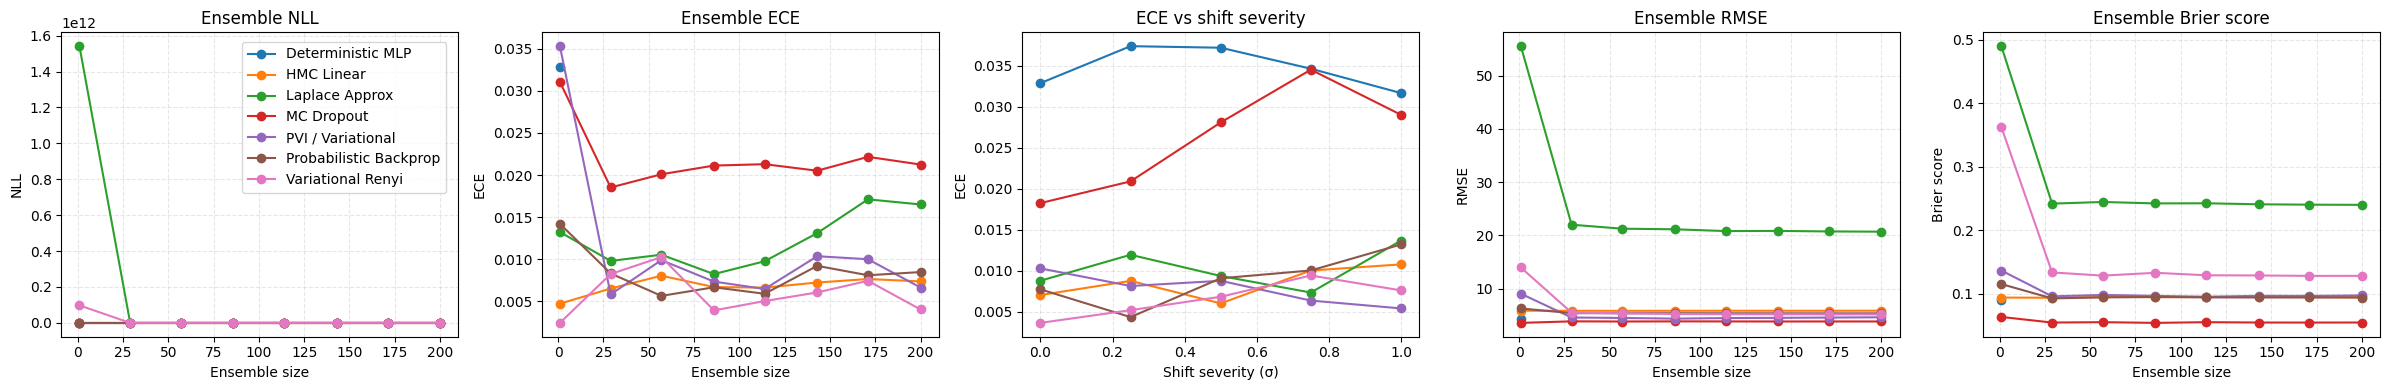

In [21]:
# Ensemble-size curves and shift calibration summary
model_names = [
    "Deterministic MLP",
    "MC Dropout",
    "HMC Linear",
    "Variational Renyi",
    "Probabilistic Backprop",
    "PVI / Variational",
    "Laplace Approx",
]

model_preds = {}
for name in model_names:
    try:
        samples, noise = predict_samples_for_model(name, test_tensor_x, n_samples=200)
        if samples.size == 0:
            continue
        model_preds[name] = {"samples": samples, "noise": noise}
    except Exception as e:
        print(f"Skipping {name}: {e}")

if not model_preds:
    print("No model predictions collected; run the training cell first.")
else:
    ensemble_rows = []
    for name, payload in model_preds.items():
        curves = metrics_vs_ensemble_size(payload["samples"], y_test_true, noise_var=payload.get("noise", 0.0))
        for row in curves:
            ensemble_rows.append({"model": name, **row})
    ensemble_curve_df = pd.DataFrame(ensemble_rows)

    severities = [0.0, 0.25, 0.5, 0.75, 1.0]
    shift_rows = []
    for sev in severities:
        shift_x = test_tensor_x if sev == 0 else test_tensor_x + sev * torch.randn_like(test_tensor_x)
        for name in model_preds.keys():
            samples, noise = predict_samples_for_model(name, shift_x, n_samples=150)
            mean, var, _ = predictive_stats(samples, noise)
            metrics = compute_basic_metrics(mean, var, y_test_true)
            shift_rows.append({"model": name, "severity": sev, "ece": metrics["ece"]})
    shift_df = pd.DataFrame(shift_rows)

    fig, axes = plt.subplots(1, 5, figsize=(24, 4))
    plot_plan = [
        ("nll", axes[0], "Ensemble NLL"),
        ("ece", axes[1], "Ensemble ECE"),
        ("shift", axes[2], "ECE vs shift severity"),
        ("rmse", axes[3], "Ensemble RMSE"),
        ("brier", axes[4], "Ensemble Brier score"),
    ]
    ylabels = {"nll": "NLL", "ece": "ECE", "rmse": "RMSE", "brier": "Brier score"}

    for metric, ax, title in plot_plan:
        if metric == "shift":
            for name, grp in shift_df.groupby("model"):
                grp = grp.sort_values("severity")
                ax.plot(grp["severity"], grp["ece"], marker="o", label=name)
            ax.set_xlabel("Shift severity (σ)")
            ax.set_ylabel("ECE")
        else:
            for name, grp in ensemble_curve_df.groupby("model"):
                grp = grp.sort_values("ensemble_size")
                ax.plot(grp["ensemble_size"], grp[metric], marker="o", label=name)
            ax.set_xlabel("Ensemble size")
            ax.set_ylabel(ylabels.get(metric, metric.upper()))
        ax.set_title(title)
        ax.grid(True, linestyle="--", alpha=0.3)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.1, 0.9))
    plt.tight_layout()
    plt.savefig('./report_metrics.jpg')
    plt.show()

## Adversarial FGSM evaluation


model  Deterministic MLP  HMC Linear  Laplace Approx  MC Dropout  \
eps                                                                
0.00            4.211161    5.857910       19.220093    3.802497   
0.05            5.794981    6.003449       20.629923    4.402586   
0.10            7.406628    6.193529       24.042818    5.158657   
0.15            8.956483    6.424199       21.712778    5.985567   
0.20           10.450456    6.691261       21.336184    6.900982   
0.30           13.129875    7.318103       22.920370    8.822926   
0.40           15.500376    8.043925       22.926588   10.754762   
0.50           17.698488    8.844396       26.395086   12.673300   
0.60           19.769951    9.701053       29.543438   14.685904   
0.70           21.792120   10.600280       27.792751   16.709873   
0.80           23.814198   11.532126       33.146561   18.716002   
0.90           25.791277   12.489292       35.187145   20.808588   
1.00           27.740587   13.466377       40.45

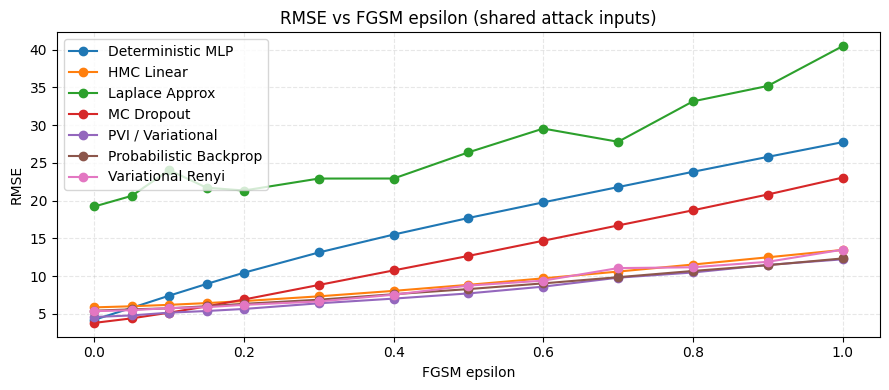

In [23]:

# Adversarial FGSM: RMSE vs epsilon for all models
epsilon_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
adv_inputs = {eps: fgsm_attack(det_model, test_tensor_x, test_tensor_y, eps) for eps in epsilon_list}

adv_rows = []
for eps, adv_x in adv_inputs.items():
    for name in [
        "Deterministic MLP",
        "MC Dropout",
        "HMC Linear",
        "Variational Renyi",
        "Probabilistic Backprop",
        "PVI / Variational",
        "Laplace Approx",
    ]:
        try:
            samples, noise = predict_samples_for_model(name, adv_x, n_samples=200)
        except Exception as e:
            print(f"Skipping {name} at eps={eps}: {e}")
            continue
        mean, var, _ = predictive_stats(samples, noise)
        metrics = compute_basic_metrics(mean, var, y_test_true)
        adv_rows.append({"model": name, "eps": eps, "rmse": metrics["rmse"], "nll": metrics["nll"], "ece": metrics["ece"]})

adv_df = pd.DataFrame(adv_rows)
print(adv_df.pivot(index="eps", columns="model", values="rmse"))

fig, ax = plt.subplots(figsize=(9, 4))
for name, grp in adv_df.groupby("model"):
    grp = grp.sort_values("eps")
    ax.plot(grp["eps"], grp["rmse"], marker="o", label=name)
ax.set_xlabel("FGSM epsilon")
ax.set_ylabel("RMSE")
ax.set_title("RMSE vs FGSM epsilon (shared attack inputs)")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig('./report_adv_attack.jpg')
plt.show()